In [16]:
from gridworld_pa1 import world, plot_Q, seq_to_col_row
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
#same actions are used for plotting the Q value graph
DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

In [18]:
#choose number 0 to 5 to enter a argument for world number
env  = world(world_num = 1)
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


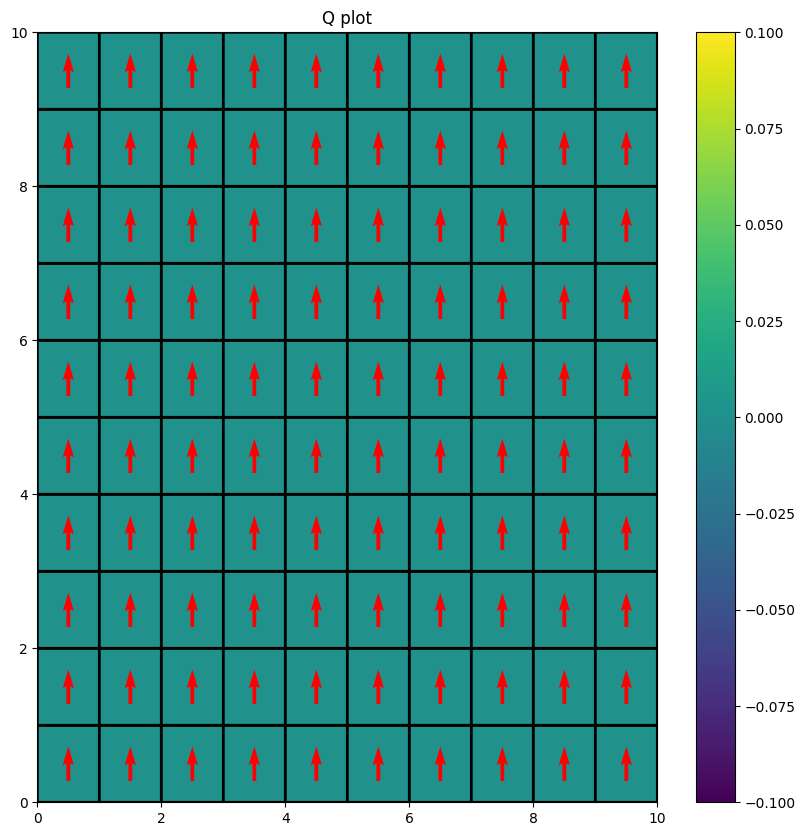

(100, 4)

In [19]:
#plot Q value
Q = np.zeros((env.num_states, env.num_actions))

plot_Q(Q)
Q.shape

In [20]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    action_probs = softmax(Q[state])
    return rg.choice(len(actions), p=action_probs)


In [21]:
alpha0 = 0.4
gamma = 0.9
episodes = 5000

In [22]:
print_freq = 100
            
def sarsa(env, Q, gamma=0.9, plot_heat=False, choose_action=choose_action_softmax):
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(state, action)
            action_next = choose_action(Q, state_next)
            
            # Update equation for SARSA
            Q[state, action] += alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next

            if state in env.goal_states_seq:
                break
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1) % print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f" % (ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                                             np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                                             Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

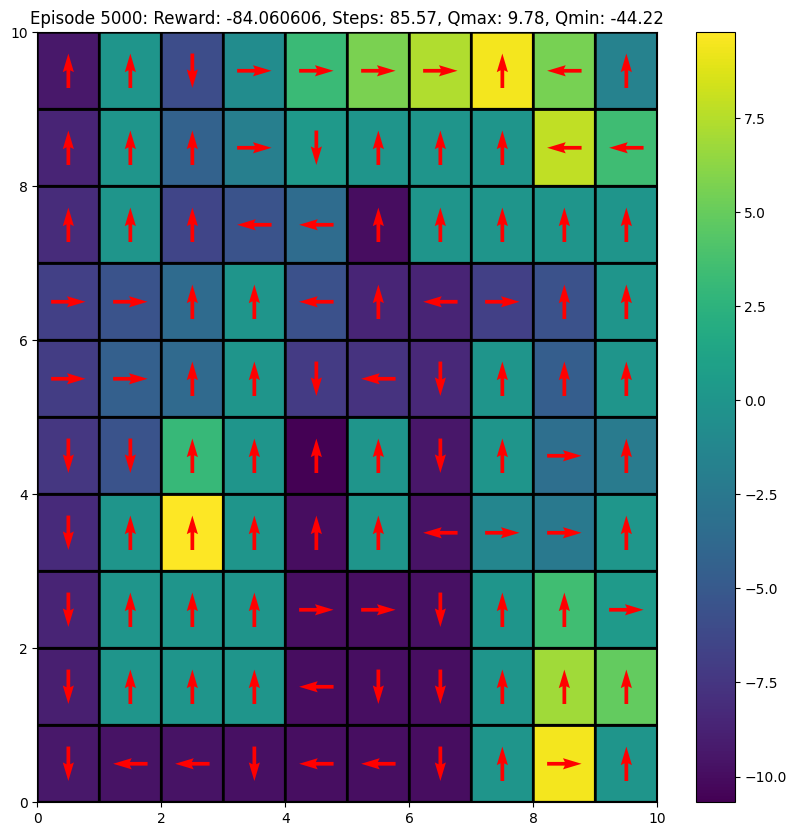

100%|██████████| 5000/5000 [00:47<00:00, 105.16it/s]


In [23]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

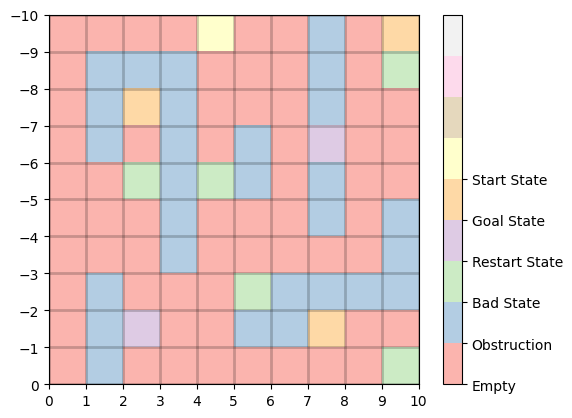

In [24]:
matrix = np.zeros((10, 10))

obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])
start_state = np.array([[0,4]])

matrix[obstructions[:, 0], obstructions[:, 1]] = 1
matrix[bad_states[:, 0], bad_states[:, 1]] = 2
matrix[restart_states[:, 0], restart_states[:, 1]] = 3
matrix[goal_states[:, 0], goal_states[:, 1]] = 4
matrix[start_state[:, 0], start_state[:, 1]] = 5


# Define colors for each element in the matrix
colors = ['white', 'black', 'red', 'blue', 'green', 'yellow']

# Plot the matrix
plt.imshow(matrix, cmap='Pastel1', vmin=0, vmax=5)

# Add grid lines
# Define the extent of the grid
extent = [0, 10, 0, -10]

# Plot the matrix with the extent
plt.imshow(matrix, cmap='Pastel1', vmin=0, vmax=9, extent=extent)

# Add grid lines
plt.grid(True, color='black', linewidth=2, alpha = 0.2)
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, -11, -1))


# Add colorbar legend
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Empty', 'Obstruction', 'Bad State', 'Restart State', 'Goal State', 'Start State'])

# Show the plot
plt.show()

